Credit: This paper is a contribution to the work of Farzad Nekouei. The study is based on his work and includes stages of data analysis and preprocessing. The data is originally from the article "Hotel Booking Demand Datasets," written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

Purpose: Obtain a clean dataset that can be used to predict the probability of hotel reservation cancellations.

Materials: Included are the initial dataset, the preprocessed dataset, and the model obtained by training the dataset with specific hyperparameters.

Model prediction: If you only want to use the model, you can skip to the end, where you will find the pretrained model and the possibility to add your own query.

Metrics: 85% Accuracy

You can find more metrics and the confusion matrix in the paper.

Credit: Ionuț Vișan (UNSTPB, Artificial Intelligence master), Poață Andrei Cătălin (UNSTPB, Artificial Intelligence master)

!! To achieve better results for your needs, we encourage you to calibrate the model according to your requirements.

Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from google.colab import files
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

Configure Seaborn plot styles: Set background color and use dark grid

In [ ]:
sns.set(rc={'axes.facecolor': 'lavender'}, style='darkgrid')

Upload original dataset

In [ ]:
uploaded = files.upload()

Saving hotel_booking.csv to hotel_booking.csv


Read original dataset

In [ ]:
df = pd.read_csv("hotel_booking.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


Print info for original dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Convert these columns to string (object) data type
for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verify the changes in data types
df.dtypes

,0
hotel,object
is_canceled,object
lead_time,int64
arrival_date_year,object
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


Get the summary statistics for numerical variables

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


Get the summary statistics for categorical variables

In [ ]:
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


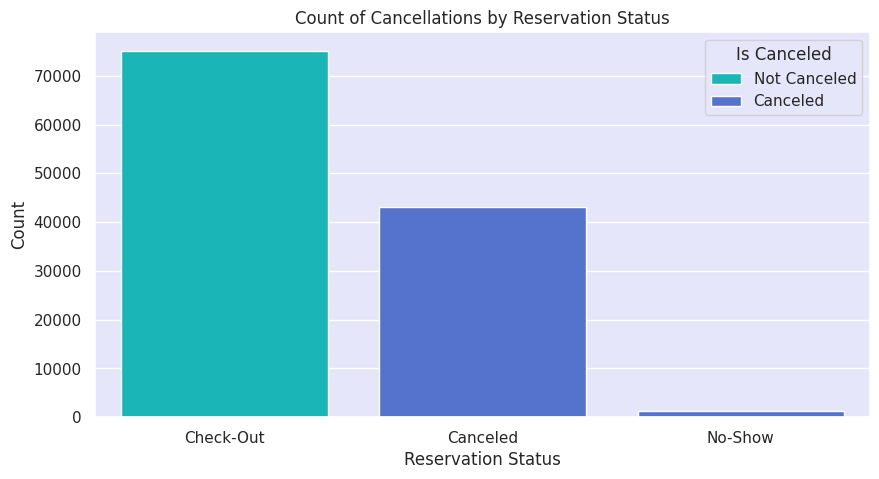

In [ ]:
# Bivariate bar plot of 'is_canceled' vs 'reservation_status' with specified colors
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

Drop the `reservation_status` feature

In [ ]:
df = df.drop(['reservation_status'], axis=1)

In [ ]:
# Convert 'reservation_status_date' to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract Days_Difference from 'reservation_status_date'
df['reservation_status_days_difference'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))).dt.days

df[['reservation_status_days_difference']].head()

,reservation_status_days_difference
0,0
1,0
2,1
3,1
4,2


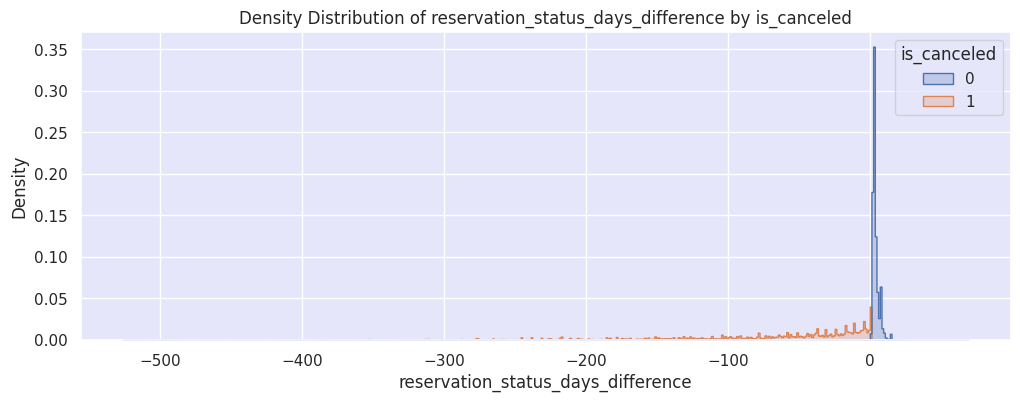

In [ ]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="reservation_status_days_difference", hue="is_canceled", element="step", stat="density", common_norm=False)
plt.title('Density Distribution of reservation_status_days_difference by is_canceled')
plt.show()

In [ ]:
# For positive values of reservation_status_days_difference
print("Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:\n")
print(df[df['reservation_status_days_difference'] > 0]['is_canceled'].value_counts())

# For negative values of reservation_status_days_difference
print("\n" + "-"*85)
print("\nDistribution of 'is_canceled' when 'reservation_status_days_difference' is negative:\n")
print(df[df['reservation_status_days_difference'] < 0]['is_canceled'].value_counts())

Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:

is_canceled
0    74460
Name: count, dtype: int64

-------------------------------------------------------------------------------------

Distribution of 'is_canceled' when 'reservation_status_days_difference' is negative:

is_canceled
1    42137
Name: count, dtype: int64


In [ ]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status_days_difference'], axis=1)

In [ ]:
df = df.drop(['assigned_room_type'], axis=1)

In [ ]:
df['arrival_date_year'].value_counts()

,count
arrival_date_year,
2016,56707
2017,40687
2015,21996


In [ ]:
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

In [ ]:
# Create a dataframe with the number of unique categories and missing values for each high-cardinality feature
high_cardinality_features = ['country', 'agent', 'company', 'name', 'email', 'phone-number', 'credit_card']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,178,0
agent,334,0
company,353,0
name,81503,0
email,115889,0
phone-number,119390,0
credit_card,9000,0


In [ ]:
# Feature Engineering for 'name' feature
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

df[['number_of_bookings']].head()

,number_of_bookings
0,1
1,2
2,3
3,1
4,1


In [ ]:
# Calculate the missing values percentage in the original dataset
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage[missing_values_percentage > 0]

,0
children,0.00335


In [ ]:
df['children'].value_counts()

,count
children,
0.0,110796
1.0,4861
2.0,3652
3.0,76
10.0,1


In [ ]:
# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

# Check if there are any missing values left in 'children' column
df['children'].isnull().sum()

0

In [ ]:
# Analyze noisy data
noisy_data = {
    'adr':      df[df['adr'] < 0],
    'adults':   df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies':   df[df['babies'] == 10],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

In [ ]:
# Replace negative adr with median of adr column
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()

# Remove rows with 0 adults
df = df[df['adults'] != 0]

# Remove rows with 10 children or 10 babies
df = df[df['children'] != 10]
df = df[df['babies'] != 10]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'adr': df[df['adr'] < 0],
    'adults': df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies': df[df['babies'] == 10],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'adr': 0, 'adults': 0, 'children': 0, 'babies': 0}

In [ ]:
df.dtypes

,0
hotel,object
is_canceled,object
lead_time,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64
children,float64


In [ ]:
# Check unique values in the 'arrival_date_month' column
unique_months = df['arrival_date_month'].unique()
print(unique_months)

[ 7  8  9 10 11 12  1  2  3  4  5  6]


In [ ]:
# Checking for the existence of columns in the dataframe
existing_columns = [col for col in one_hot_cols if col in df.columns]
missing_columns = [col for col in one_hot_cols if col not in df.columns]

print("Existing columns for one-hot encoding:", existing_columns)
print("Missing columns:", missing_columns)

# Applying one-hot encoding on the existing columns
df = pd.get_dummies(df, columns=existing_columns, drop_first=True)

df.info()

Coloane existente pentru one-hot encoding: []
Coloane lipsă: ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  object 
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                    

In [ ]:
# Display the first rows to check the new columns
print(df.head())

# Check dataframe information to see the new columns and their types
df.info()

  is_canceled  lead_time  arrival_date_month  arrival_date_week_number  \
0           0        342                   7                        27   
1           0        737                   7                        27   
2           0          7                   7                        27   
3           0         13                   7                        27   
4           0         14                   7                        27   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          1                        0                     0   
1                          1                        0                     0   
2                          1                        0                     1   
3                          1                        0                     1   
4                          1                        0                     2   

   adults  children  babies  ... reserved_room_type_E  reserved_room_type_F  \
0

In [ ]:
# Converting 'is_canceled' and 'is_repeated_guest' columns to numeric format
df['is_canceled'] = df['is_canceled'].astype(int)
df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

# Checking the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

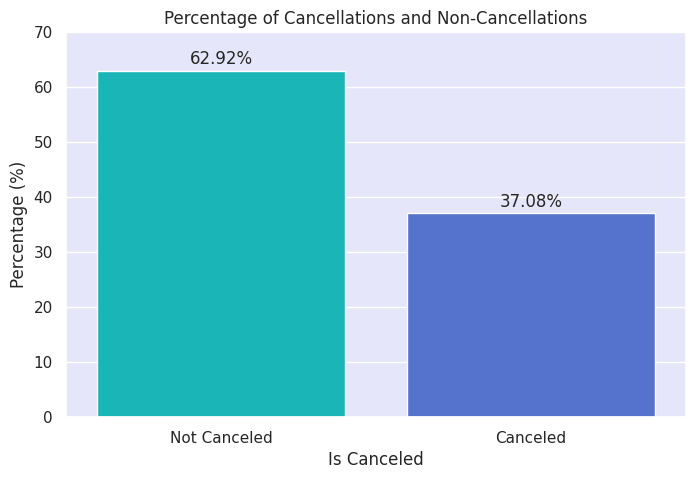

In [ ]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,7,27,1,0,0,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,737,7,27,1,0,0,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,7,7,27,1,0,1,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,13,7,27,1,0,1,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,14,7,27,1,0,2,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Save the cleaned dataframe to a CSV file
cleaned_file_path = 'cleaned_hotel_booking.csv'
df.to_csv(cleaned_file_path, index=False)

# Download the file
from google.colab import files
files.download(cleaned_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Define features (X) and labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model with very high hyperparameters
xgb_base = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0,
    n_estimators=1000,  # number of trees
    max_depth=15,       # maximum depth of each tree
    learning_rate=0.005,  # learning rate
    subsample=0.9,      # proportion of samples used to train each tree
    colsample_bytree=0.9  # proportion of features used to train each tree
)

# Train the model
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

Accuracy: 0.8495188469134765
Precision: 0.8514347009922231
Recall: 0.7197098492576222
F1 Score: 0.7800503654566674


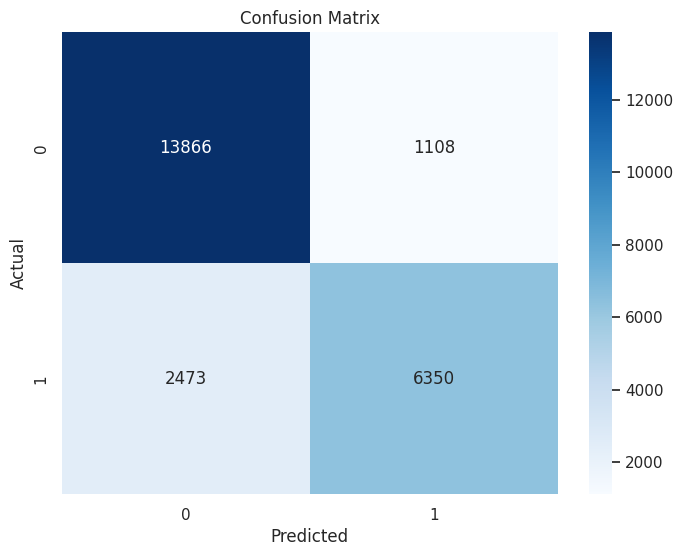

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     14974
           1       0.85      0.72      0.78      8823

    accuracy                           0.85     23797
   macro avg       0.85      0.82      0.83     23797
weighted avg       0.85      0.85      0.85     23797



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = xgb_base.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_test, y_pred))

In [ ]:
import joblib

# Save the trained model to a file
model_path = 'xgb_model.pkl'
joblib.dump(xgb_base, model_path)

['xgb_model.pkl']

In [ ]:
from google.colab import files

# Download the saved model file
files.download(model_path)

In [ ]:
# Select a query from the test set
query_index = 4  # You can change this index to select another query
query = X_test.iloc[query_index].values.reshape(1, -1)
actual = y_test.iloc[query_index]

# Display the query
print("Query:")
print(X_test.iloc[query_index])

Interogarea:
lead_time                           135
arrival_date_month                    2
arrival_date_week_number              8
arrival_date_day_of_month            23
stays_in_weekend_nights               2
stays_in_week_nights                  3
adults                                2
children                            2.0
babies                                0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
booking_changes                       0
days_in_waiting_list                  0
adr                               174.0
required_car_parking_spaces           0
total_of_special_requests             0
number_of_bookings                    3
hotel_Resort Hotel                False
meal_FB                           False
meal_HB                           False
meal_SC                           False
meal_Undefined                    False
market_segment_Complementary      False
market_segment_Corporate   

In [ ]:
# Load the model from the file
xgb_loaded = joblib.load(model_path)

# Make predictions using the loaded model
proba = xgb_loaded.predict_proba(query)

# Display probabilities and the actual value
print(f"Probability of not canceling the reservation: {proba[0][0] * 100:.2f}%")
print(f"Probability of canceling the reservation: {proba[0][1] * 100:.2f}%")
print(f"Actual value: {actual}")

Probabilitatea de a nu anula rezervarea: 45.27%
Probabilitatea de a anula rezervarea: 54.73%
Valoarea reală: 1


                      Feature  Importance
42    deposit_type_Non Refund    0.410568
28   market_segment_Online TA    0.125026
16  total_of_special_requests    0.119806
10     previous_cancellations    0.071840
0                   lead_time    0.069780


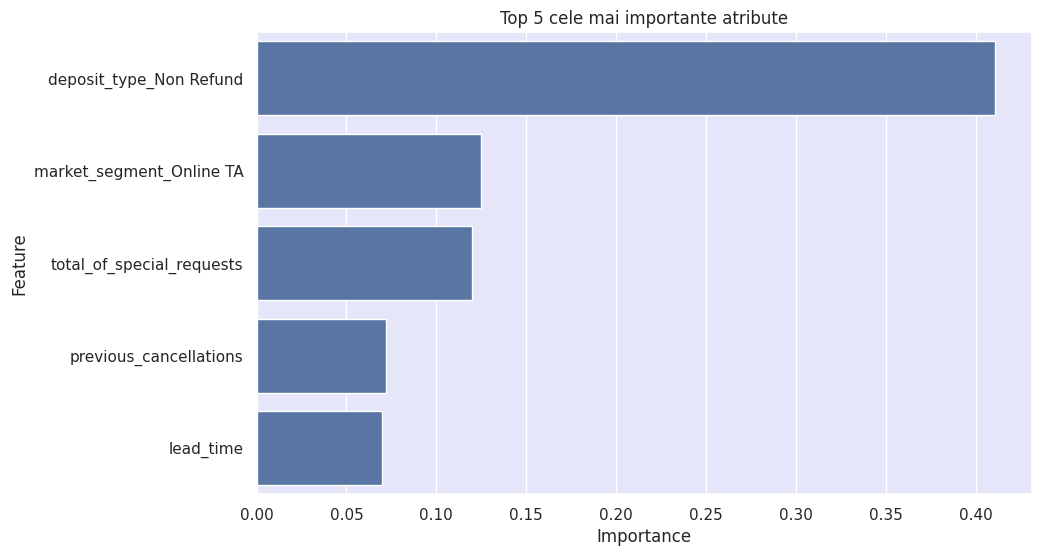

In [ ]:
# Obtain feature importances
importances = xgb_loaded.feature_importances_

# Create a dataframe for features and their importances
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top 5 features
top_5_features = feature_importances.head(5)
print(top_5_features)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_5_features)
plt.title('Top 5 Most Important Features')
plt.show()